In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix , f1_score, accuracy_score,precision_score , recall_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import joblib


In [10]:
data = pd.read_csv('finalized_preprocessed_data.csv')

In [11]:
X = data.drop(columns='is_fraud')
y = data['is_fraud']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [12]:

X_sample = X_resampled.sample(n = 500000, random_state = 42)
y_sample = y_resampled.loc[X_sample.index]
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)


In [ ]:
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}
'''
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,   
    cv=2,       
    n_jobs=-1,
    verbose=2,
    random_state=42
)

rf_random.fit(X_train, y_train)
'''
print("Best params:", rf_random.best_params_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.2min
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.3min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.3min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.3min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.5min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.5min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 2.4min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 2.3min
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=

In [ ]:
# rf_model= joblib.dump(rf_random, 'randomforest_model.pkl')

In [5]:
rf_model = joblib.load('randomforest_model.pkl')

In [28]:
import mlflow 
import mlflow.sklearn

client = mlflow.tracking.MlflowClient()
mlflow.set_tracking_uri("http://127.0.0.1:8080")

In [ ]:
'''
experiment_description = "Random Forest Model"
experiment_tags = {
    "model_type": "Random Forest",
    "dataset": "Credit Card Fraud",
    "model_version": "v1.2"
}

produced_model = client.create_experiment(
    name="Random Forest Model-credit_card Fraud_dectection1",
    artifact_location="./mlruns",
    tags=experiment_tags
)
'''

RestException: RESOURCE_ALREADY_EXISTS: Experiment 'Random Forest Model-credit_card Fraud_dectection1' already exists.

In [ ]:
y_pred = rf_model.predict(X_test)

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
confusion_matrix(y_test, y_pred)


metric = {
    "f1_score": f1,
    "precision": precision,
    "recall": recall
    }

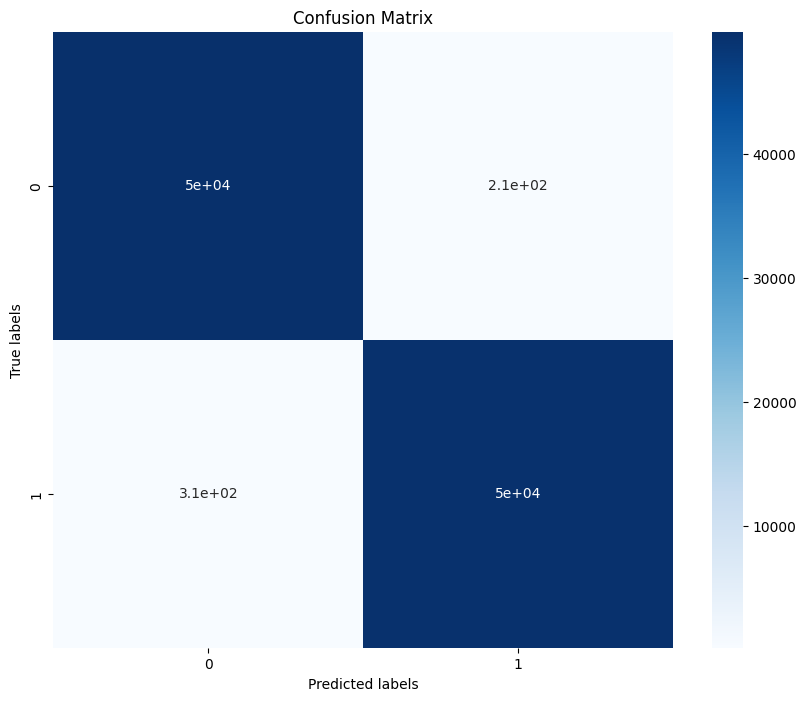

In [31]:
#plt confusion matrix

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap="Blues")

plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [32]:
report = classification_report(y_test, y_pred, output_dict=True)
report

{'0': {'precision': 0.993798851491466,
  'recall': 0.9957644896409805,
  'f1-score': 0.9947806995658899,
  'support': 50053.0},
 '1': {'precision': 0.9957470710961323,
  'recall': 0.993773399803792,
  'f1-score': 0.9947592564757753,
  'support': 49947.0},
 'accuracy': 0.99477,
 'macro avg': {'precision': 0.9947729612937991,
  'recall': 0.9947689447223862,
  'f1-score': 0.9947699780208326,
  'support': 100000.0},
 'weighted avg': {'precision': 0.9947719287374086,
  'recall': 0.99477,
  'f1-score': 0.9947699893856703,
  'support': 100000.0}}

In [ ]:

input_example = pd.DataFrame(X_train[:5], columns = X_train.columns)
with mlflow.start_run(experiment_id=produced_model) as run:
    mlflow.log_param("param_dist", rf_model.get_params())
    mlflow.log_metrics(metric)
    mlflow.log_dict(report, "classification_report.json")
    mlflow.lightgbm.log_model(rf_model, "model",input_example=input_example)

2025/09/26 15:12:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/seven/Internship/venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/seven/Internship/venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema conta

🏃 View run smiling-mare-8 at: http://127.0.0.1:8080/#/experiments/337475993542818225/runs/03d0915a8d61430aad827281386c72be
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/337475993542818225


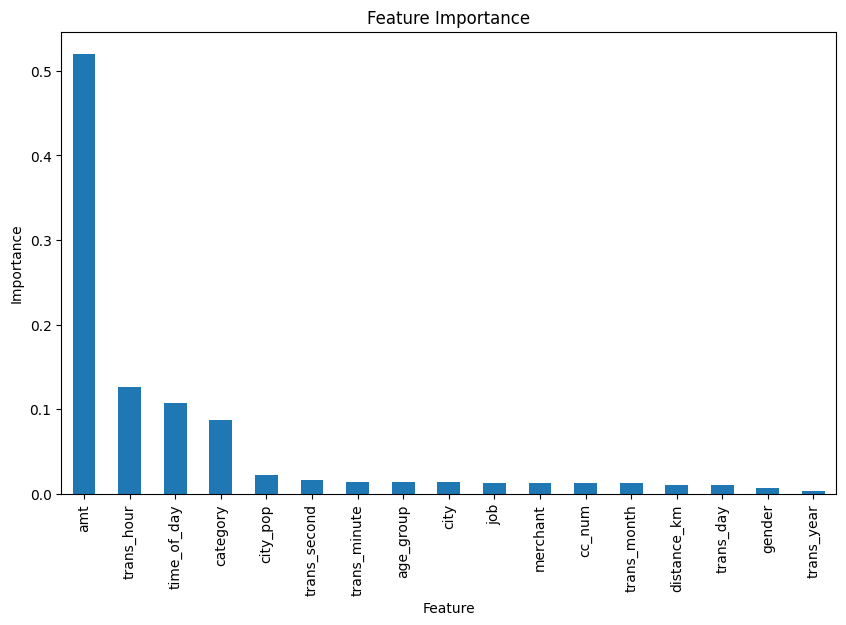

In [39]:
import matplotlib.pyplot as plt
feature_importance = rf_model.best_estimator_.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False, figsize=(10,6))
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()


In [8]:
best_model = rf_model.best_estimator_

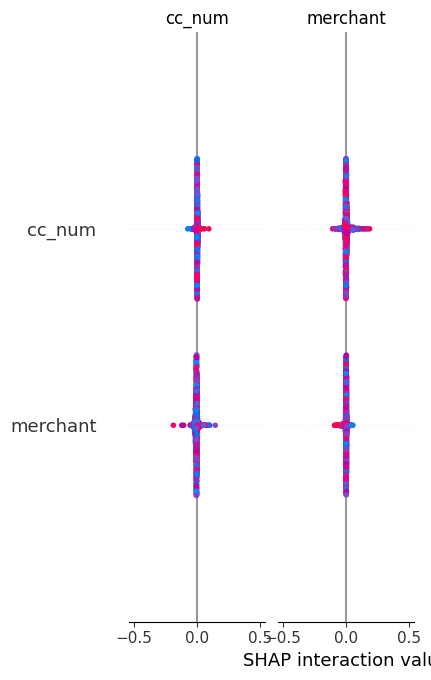

In [13]:
#using shap
import shap
explainer = shap.TreeExplainer(best_model)
sample_X = X_train.sample(n = 1000, random_state = 42)

shap_values = explainer.shap_values(sample_X)
shap.summary_plot(shap_values, sample_X, plot_type="bar", show=False)